In [36]:
# Data Preprocessing

import pandas as pd

def get_new_feature_name_df(new_df):
    file = '/Users/minjeong/Downloads/UCI HAR Dataset-2/features.txt'
    features_df = pd.read_csv(file, sep='\s+', header=None, names=['column_index', 'column_name'])

    features_cc = features_df.groupby('column_name').cumcount() 
    features_cc = pd.DataFrame(features_cc) 
    features_cc.columns = ['cumcount'] 
    
    features_cc = features_cc.reset_index() 
    features_df = features_df.reset_index() 

    new_df = pd.merge(features_cc, features_df, on='index', how='outer')
 
    new_df = new_df.drop(['index'], axis=1) 
    new_df['column_name'] = new_df[['column_name', 'cumcount']].apply(lambda x: x[0]+'_'+str(x[1])                                                               if x[1]>0 else x[0], axis=1)

    new_df = new_df.drop(['cumcount'], axis=1) 
    
    return new_df
    

def get_human_dataset():
    feature_name_df = pd.read_csv('/Users/minjeong/Downloads/UCI HAR Dataset-2/features.txt',sep='\s+',
                        header=None, names=['column_index','column_name']) 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('/Users/minjeong/Downloads/UCI HAR Dataset-2/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('/Users/minjeong/Downloads/UCI HAR Dataset-2/test/X_test.txt',sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('/Users/minjeong/Downloads/UCI HAR Dataset-2/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('/Users/minjeong/Downloads/UCI HAR Dataset-2/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

# 결정트리에 GridSearchCV 적용

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier()

params = {'max_depth':[6,8,10], 'min_samples_split':[16]}
grid = GridSearchCV(dt, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid.fit(X_train, y_train)

print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid.best_params_)
cv_results_df = pd.DataFrame(grid.cv_results_) 

cv_results_df[['param_max_depth', 'mean_test_score']]

Fitting 5 folds for each of 3 candidates, totalling 15 fits
GridSearchCV 최고 평균 정확도 수치:0.8496
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 10, 'min_samples_split': 16}


,param_max_depth,mean_test_score
0,6,0.843309
1,8,0.847396
2,10,0.849576


# 결과값 확인

In [35]:
pred = grid.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))
print('세팅한 파라미터:', grid.best_estimator_.get_params(), '\n')

dt_comp = DecisionTreeClassifier()
dt_comp.fit(X_train, y_train)
print('GridSearchCV 적용X:{0:.4f}'.format(accuracy_score(y_test, dt_comp.predict(X_test))))
print('GridSearchCV 적용X 파라미터:', dt_comp.get_params())

결정 트리 예측 정확도:0.8653
세팅한 파라미터: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 

GridSearchCV 적용X:0.8541
GridSearchCV 적용X 파라미터: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


# Feature Importance 확인

In [37]:
ftr_importances_values = grid.best_estimator_.feature_importances_

ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_importances.sort_values(ascending=False)

tGravityAcc-min()-X                0.246619
fBodyAccJerk-bandsEnergy()-1,16    0.206932
angle(Y,gravityMean)               0.136654
fBodyAccMag-energy()               0.112409
tGravityAcc-arCoeff()-Z,2          0.098848
                                     ...   
tBodyAccMag-max()                  0.000000
tBodyAccMag-mad()                  0.000000
tBodyAccMag-std()                  0.000000
tBodyAccMag-mean()                 0.000000
angle(Z,gravityMean)               0.000000
Length: 561, dtype: float64

# 시각화

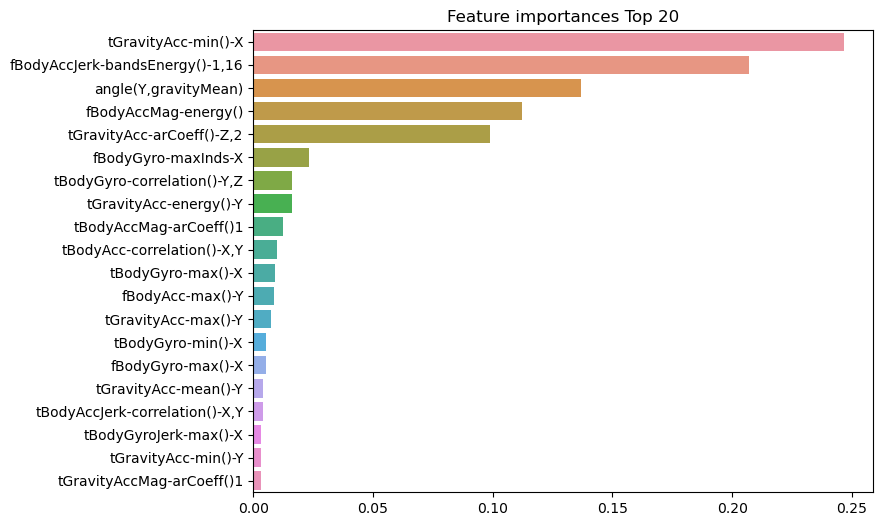

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()